# Event Detection 1.1

The current event detection implementation:

In [7]:
def detect(time_series, threshold):
	"""
	Detects a list of events events in a result set returned from the db. An event is defined
	as a increase or descrease in power that is above some threshold.

	:param time_series: a generator created by the retrieve_within_filters function
						contains dates and power readings
	:param threshold: the threshold value for event detection
	:return eventList: a python matrix containing a list of times for detected events
	"""
	if threshold == 0:
		raise Exception("Threshold cannot be 0, try another value.")

	def convert_to_float(data_point):
		data = list(data_point)
		data[1] = float(data[1])
		return data

	response_list = list(map(convert_to_float, time_series[1:]))

	event_list = []

	t1 = response_list[0]
	t2 = response_list[1]
	t3 = response_list[2]
	t4 = response_list[3]
	t5 = response_list[4]
	t6 = response_list[5]

	prev_avg = (t1[1] + t2[1] + t3[1] + t4[1] + t5[1]) / 5
	curr_avg = (t2[1] + t3[1] + t4[1] + t5[1] + t6[1]) / 5

	for i, data in enumerate(response_list[7:], start=6):

		if (curr_avg / prev_avg) > threshold:
			event_list.append(tuple([t4[0], "rising"]))
		if (curr_avg / prev_avg) < (1 / threshold):
			event_list.append(tuple([t4[0], "falling"]))

		t1 = t2
		t2 = t3
		t3 = t4
		t4 = t5
		t5 = t6
		t6 = response_list[i]
		prev_avg = (t1[1] + t2[1] + t3[1] + t4[1] + t5[1]) / 5
		curr_avg = (t2[1] + t3[1] + t4[1] + t5[1] + t6[1]) / 5

	return event_list

Here is an example of the style of data we currently have:

"Date & Time","use [kW]","gen [kW]","MaxVrmsA [V]","MaxVrmsB [V]","NetMeter [kW]","Consumption [kW]","PowerS [kW]","PowerG [kW]","Panel1 [kW]","Panel2 [kW]","Panel3 [kW]","VrmsA [V]","VrmsB [V]","I11 [A]","I12 [A]","I21 [A]","I22 [A]","I31 [A]","I32 [A]","F2 [Hz]","F1 [Hz]","Shed [kW]"
2016-01-15 18:18:59,-0.681000000,-0.006000000,117.750005593,118.216005615,-0.687000000,-0.681000000,-0.006000000,-0.000000000,-0.084000000,-0.267000000,-0.328000000,117.750005593,118.216005615,0.794000038,0.288000014,1.735000082,1.213000058,3.272000155,0.288000014,60.021002851,59.994002850,-0.002000000
2016-01-15 18:18:58,-0.679000000,-0.007000000,117.726005592,118.185005613,-0.686000000,-0.679000000,-0.007000000,-0.000000000,-0.083000000,-0.268000000,-0.327000000,117.726005592,118.185005613,0.794000038,0.289000014,1.742000083,1.215000058,3.271000155,0.288000014,59.993002850,60.007002850,-0.001000000
2016-01-15 18:18:57,-0.686000000,-0.006000000,117.791005595,118.258005617,-0.692000000,-0.686000000,-0.006000000,-0.000000000,-0.084000000,-0.272000000,-0.327000000,117.791005595,118.258005617,0.795000038,0.290000014,1.786000085,1.217000058,3.270000155,0.289000014,60.008002850,60.026002851,-0.003000000
2016-01-15

Our function requires a matrix which looks like this:

[timestamp,(power/current/voltage reading)]<br>[...]

Now loading and parsing csv file to proper format:

In [8]:
import csv

#here we are using 12 hours of data
with open('dataSample12h.csv', 'rb') as f:
    reader = csv.reader(f)
    plug_data = list(reader)

print plug_data[1]

['2016-01-15 06:19:00', '-0.361000000', '-0.006000000', '119.019005653', '119.765005689', '-0.367000000', '-0.361000000', '-0.006000000', '-0.000000000', '-0.085000000', '-0.173000000', '-0.101000000', '119.019005653', '119.765005689', '0.828000039', '0.299000014', '1.640000078', '0.301000014', '1.015000048', '0.131000006', '59.985002849', '59.987002849', '-0.002000000']


In [9]:
#lets look at Panel1 (timestamp @ index 0, Panel 1 @ index 9)
from datetime import datetime as dt

detectArray = []

for seconds in plug_data:
    time = dt.strptime(seconds[0], "%Y-%m-%d %H:%M:%S")
    detectArray.append([time,float(seconds[9])])
    
print detectArray[1]

[datetime.datetime(2016, 1, 15, 6, 19), -0.085]


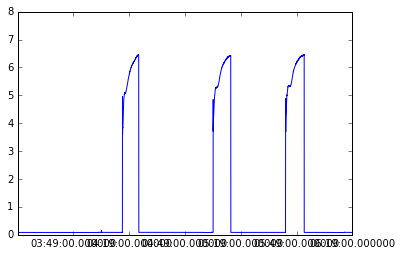

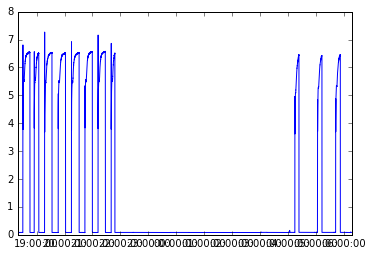

In [10]:
%matplotlib inline  
#here's the data graphed
#seen here http://stackoverflow.com/questions/19079143/how-to-plot-time-series-in-python
import numpy as np
import pylab as pl

timestamp = []
reading = []
iter = 0

for i in detectArray:
    iter += 1
    
    timestamp.append(i[0])
    #multiplying by -1 for positive readings
    reading.append(-1*i[1])

x = np.array(timestamp)
y = np.array(reading)

pl.plot(x,y)
#plot first last hours (lower indexcies indicate closer to present)
pl.xlim(timestamp[3600*3],timestamp[0])
pl.show()

pl.plot(x,y)
#plot entire 
pl.show()

Now that we have the data in to proper format, lets test our the run time of the current script (as well as the number of events detected, just to make sure that doesnt change, threshold set to 3):

In [11]:
import time

print len(detect(detectArray,3))

start = time.time()
detect(detectArray,3)

print 'It took', time.time()-start, 'seconds.'

15
It took 0.0756831169128 seconds.


In [12]:
#using numpy arrays is slower, we don't use this, just testing
npDetect = np.array(detectArray)

print len(detect(npDetect,3))

start = time.time()
detect(npDetect,3)

print 'It took', time.time()-start, 'seconds.'

15
It took 0.104887008667 seconds.


In [13]:
#proposed change to detect():
def newdetect(time_series, threshold, windowSize=5):
    """
    Detects a list of events events in a result set returned from the db. An event is defined
    as a increase or descrease in power that is above some threshold.

    :param time_series: a generator created by the retrieve_within_filters function
                        contains dates and power readings
    :param threshold: the threshold value for event detection
    :param windowSize(default=5): window size of sliding window
    :return eventList: a python matrix containing a list of times for detected events
    """
    if threshold == 0:
        raise Exception("Threshold cannot be 0, try another value.")

    if windowSize < 2:
        raise Exception("Window must have a value of at least 2.")
        
    def convert_to_float(data_point):
        data = list(data_point)
        data[1] = float(data[1])
        return data

    response_list = list(map(convert_to_float, time_series[1:]))

    #load in first values to the window based on windowSize parameter (default 5)
    #here we load up and extra value to get the first and second averages
    window_list = response_list[:windowSize]
    prev_avg = sum(item[1] for item in window_list)/windowSize
    
    #first slide
    window_list = response_list[1:windowSize+1]
    curr_avg = sum(item[1] for item in window_list)/windowSize
            
    event_list = []
    
    counter = 2    
    center = windowSize/2
    for i, data in enumerate(response_list[7:], start=6):
                   
        #check for delta change above/below a threshold
        if (curr_avg / prev_avg) > threshold:
            event_list.append(tuple([window_list[center][0], "rising"]))
        if (curr_avg / prev_avg) < (1 / threshold):
            event_list.append(tuple([window_list[center][0], "falling"]))
       
        #slide and update averages
        window_list = response_list[counter:counter+windowSize]
        prev_avg = curr_avg
        curr_avg = sum(item[1] for item in window_list)/windowSize
        
        counter += 1
                   
    return event_list

In [14]:
#lets try it out

start = time.time()
detect(detectArray,3)

print 'The old detect took', time.time()-start, 'seconds.'

start = time.time()
newdetect(detectArray,3)

print 'The new detect took', time.time()-start, 'seconds.'

The old detect took 0.0530149936676 seconds.
The new detect took 0.0896439552307 seconds.


Although this new event detection module is a bit slower, the addition of an elastic window size increases its functionality by a significant amount (The division operation for the center calculation seems to add the most time). The cause for the descrepency in run time should be investigated further, please let me know if you have any ideas.

In [16]:
#lets see some other window sizes

start = time.time()
newdetect(detectArray,3,2)

print 'Window of 2 took', time.time()-start, 'seconds.'

start = time.time()
newdetect(detectArray,3,10)

print 'Window of 10 took', time.time()-start, 'seconds.'

Window of 2 took 0.111217021942 seconds.
Window of 10 took 0.0659201145172 seconds.


In [17]:
#error case
newdetect(detectArray,3,1)

Exception: Window must have a value of at least 2.